<a href="https://colab.research.google.com/github/kamilakhtar015/Machine-Learning---Concepts-GSU-/blob/main/Naive_Bayes_Classifier_for_Buyers_Attitude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("This is the Extra Assignment of ML Course")

This is the Extra Assignment of ML Course


In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Preprocessing

1. Convert text to lowercase

2. Remove punctuation, special characters, numbers

3. Tokenize text (split into words)

4. Remove stopwords like “the”, “is”, “and”

In [ ]:
reviews = pd.read_csv("/content/amazon_reviews.csv")

print(reviews.shape)
reviews.head()

(101, 2)


,Review,Label
0,This iOttie CD slot mount is exactly what I ne...,Positive
1,"Easy to install, easy to manipulate, decent ma...",Positive
2,This is a GREAT product! I put this off to the...,Positive
3,I rarely write reviews but this product is soo...,Positive
4,Bought the first gen of this back in 2019. It ...,Positive


In [ ]:
def preprocess_text(text):
  # Changing to lowercase
  text = str(text).lower()

  # Removing punctuation, special charachters, numbers
  text = re.sub(r'[^a-z\s]', '', text)

  # Tokenize
  words = text.split()

  # Remove stopwords
  stop_words = set(stopwords.words('english'))
  words = [word for word in words if word not in stop_words]

  return ' '.join(words)

In [ ]:
reviews["Tokens"] = reviews["Review"].apply(preprocess_text)

In [ ]:
reviews.head()

,Review,Label,Tokens
0,This iOttie CD slot mount is exactly what I ne...,Positive,iottie cd slot mount exactly needed installs e...
1,"Easy to install, easy to manipulate, decent ma...",Positive,easy install easy manipulate decent manufactur...
2,This is a GREAT product! I put this off to the...,Positive,great product put bottom corner driver side wi...
3,I rarely write reviews but this product is soo...,Positive,rarely write reviews product sooo good mounted...
4,Bought the first gen of this back in 2019. It ...,Positive,bought first gen back fell maybe one time othe...


# Identify Keywords and Build Binary Feature Vectors

### Select Top 10 Keywords

In [ ]:
from collections import Counter

# Split by label
positive_tokens = " ".join(reviews[reviews["Label"] == "Positive"]["Tokens"]).split()
negative_tokens = " ".join(reviews[reviews["Label"] == "Negative"]["Tokens"]).split()

# Get frequencies
positive_freq = Counter(positive_tokens)
negative_freq = Counter(negative_tokens)

print("Positive top words:", positive_freq.most_common(15))
print("Negative top words:", negative_freq.most_common(15))


Positive top words: [('phone', 56), ('mount', 34), ('easy', 24), ('one', 24), ('car', 22), ('great', 16), ('suction', 15), ('use', 15), ('product', 12), ('time', 11), ('holder', 11), ('iottie', 10), ('cup', 10), ('place', 10), ('holds', 9)]
Negative top words: [('phone', 62), ('mount', 42), ('one', 34), ('dash', 32), ('would', 27), ('product', 26), ('suction', 24), ('dashboard', 22), ('car', 21), ('cup', 19), ('get', 19), ('even', 19), ('cd', 19), ('well', 17), ('disc', 17)]


### Build Binary Feature Vectors Using Frequent Words

In [ ]:
selected_keywords = [
    "phone", "mount", "easy", "great", "use",     # mostly positive
    "suction", "dash", "would", "holder", "get"   # more common in negative
]

for kw in selected_keywords:
  reviews[kw] = reviews["Tokens"].apply(lambda x: 1 if kw in x else 0)


print(reviews[selected_keywords + ["Label"]].head())

   phone  mount  easy  great  use  suction  dash  would  holder  get     Label
0      1      1     1      1    0        0     1      0       0    0  Positive
1      1      1     1      1    0        1     1      1       0    1  Positive
2      0      0     0      1    0        0     1      0       0    0  Positive
3      1      1     0      0    0        1     0      0       1    0  Positive
4      1      0     0      0    1        0     0      0       0    0  Positive


# Implementing Naive Bayes Classifier

### Split into train and validation sets

In [ ]:
# Shuffle the dataset
reviews_shuffled = reviews.sample(frac=1, random_state=42).reset_index(drop=True)

print(reviews_shuffled.shape)
print(reviews_shuffled.head())

# split
train_df = pd.concat([
    reviews_shuffled[reviews_shuffled["Label"] == "Positive"][:40],
    reviews_shuffled[reviews_shuffled["Label"] == "Negative"][:40]
])

test_df = pd.concat([
    reviews_shuffled[reviews_shuffled["Label"] == "Positive"][40:50],
    reviews_shuffled[reviews_shuffled["Label"] == "Negative"][40:50]
])

features = selected_keywords

(101, 13)
                                              Review     Label  \
0  They didnt home up the phone high. They say I ...  Negative   
1  The adhesive fails in heat resistance. 60F out...  Negative   
2  The dashboard adhesive would be better if it h...  Negative   
3  This mount will not stay. It he longest the su...  Negative   
4                     Works great.  Buying a second.  Positive   

                                              Tokens  phone  mount  easy  \
0  didnt home phone high say use vent holding ver...      1      0     0   
1  adhesive fails heat resistance f outside air t...      0      1     0   
2  dashboard adhesive would better flexibility al...      1      1     0   
3  mount stay longest suction held phone mount ma...      1      1     0   
4                          works great buying second      0      0     0   

   great  use  suction  dash  would  holder  get  
0      0    1        0     0      0       0    0  
1      0    0        0     0      

### Train Naïve Bayes

In [ ]:
import numpy as np

def train_naive_bayes(df, features):
  classes = df["Label"].unique()
  priors = {}
  likelihoods = {}

  for c in classes:
    class_df = df[df["Label"] == c]
    priors[c] = len(class_df) / len(df)
    likelihoods[c] = {}

    for feature in features:
      # Laplace smoothing: add 1 to numerator, 2 to denominator
      prob = (class_df[feature].sum() + 1) / (len(class_df) + 2)
      likelihoods[c][feature] = prob

  return priors, likelihoods


### Predict Using Naïve Bayes

In [ ]:
def predict_naive_bayes(row, priors, likelihoods, features):
  posteriors = {}

  for c in priors:
    # use to avoid overflow
    log_prob = np.log(priors[c])
    for f in features:
      if row[f] == 1:
        log_prob += np.log(likelihoods[c][f])
      else:
        log_prob += np.log(1 - likelihoods[c][f])
    posteriors[c] = log_prob

  return max(posteriors, key=posteriors.get)

### Evaluate Accuracy on Test Set

In [ ]:
# Train
priors, likelihoods = train_naive_bayes(train_df, features)

# Predict
test_df["Predicted"] = test_df.apply(lambda row: predict_naive_bayes(row, priors, likelihoods, features), axis=1)

# Accuracy
accuracy = (test_df["Predicted"] == test_df["Label"]).mean()
print("Accuracy:", accuracy)

# Confusion matrix
print(pd.crosstab(test_df["Label"], test_df["Predicted"], rownames=["Actual"], colnames=["Predicted"]))

Accuracy: 0.65
Predicted  Negative  Positive
Actual                       
Negative          6         4
Positive          3         7


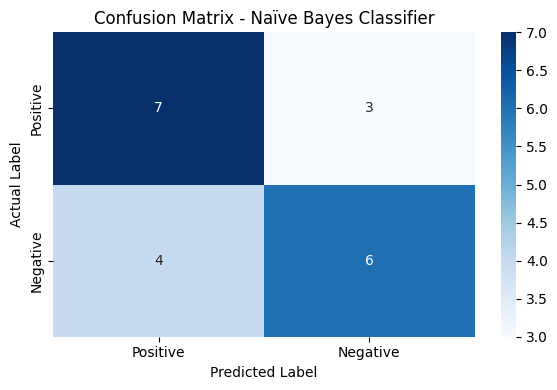

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# True vs Predicted labels
y_true = test_df["Label"]
y_pred = test_df["Predicted"]

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=["Positive", "Negative"])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Positive", "Negative"],
            yticklabels=["Positive", "Negative"])

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Naïve Bayes Classifier")
plt.tight_layout()
plt.show()
